# Config

In [3]:
from __future__ import print_function
from pyspark import SparkContext , SparkConf
import sys
from operator import add
from csv import reader
from pyspark.sql import SQLContext, SparkSession

In [4]:
from pyspark.sql.functions import col, lit, when, signum, avg, count, sum, round

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
cf = SparkConf()
cf.set("spark.submit.deployMode","client")

sc = SparkContext.getOrCreate(cf)

spark = SparkSession.builder.appName("Analysis_RDS").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 02:56:13 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/11 02:56:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/11 02:56:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/11 02:56:13 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


# Top-5 league comparison 2015/16 season   

In [13]:
#Data cohort for consideration
leagues = ['La Liga']
team_id = [217]
season = [f'20{str(_)}/20{str(_+1)}' for _ in range(10,20)]
season_id = [22,23,24,25,26,27,2,1,4,42]
gender = 'male'

In [11]:
filepath = 'Project/Data/Format_data/matches.parquet'
df_matches_data = spark.read.parquet(filepath)
df_matches_data.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team_away_team_gender: string (nullable = true)
 |-- away_team_away_team_group: string (nullable = true)
 |-- away_team_away_team_id: long (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- away_team_managers_country_id: long (nullable = true)
 |-- away_team_managers_country_name: string (nullable = true)
 |-- away_team_managers_name: string (nullable = true)
 |-- away_team_managers_dob: string (nullable = true)
 |-- away_team_managers_id: long (nullable = true)
 |-- away_team_managers_nickname: string (nullable = true)
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- competition_country_name: string (nullable = true)
 |-- competition_stage_id: long (nullable = true)
 |-- competition_stage_name: string (nullable = true)
 |-- home_score: long (nullable = true)
 |-- home_team_home_team_gender: string (nullable = true)
 |-- home_team_ho

In [12]:
filepath = 'Project/Data/Format_data/competitions.parquet'
df_comp_data = spark.read.parquet(filepath)
df_comp_data.printSchema()

root
 |-- competition_gender: string (nullable = true)
 |-- competition_id: long (nullable = true)
 |-- competition_international: boolean (nullable = true)
 |-- competition_name: string (nullable = true)
 |-- competition_youth: boolean (nullable = true)
 |-- country_name: string (nullable = true)
 |-- match_available: string (nullable = true)
 |-- match_available_360: string (nullable = true)
 |-- match_updated: string (nullable = true)
 |-- match_updated_360: string (nullable = true)
 |-- season_id: long (nullable = true)
 |-- season_name: string (nullable = true)



In [14]:
df_comp_focus = df_comp_data.filter((df_comp_data.competition_name.isin(leagues)) &
                   (df_comp_data.season_id.isin(season_id)))

In [15]:
## Getting all matches based on the competition in focus

condition = [(df_matches_data.competition_competition_id == df_comp_focus.competition_id) &
             (df_matches_data.season_season_id == df_comp_focus.season_id)]

df_match_focus = df_matches_data.filter((col('home_team_home_team_id').isin(team_id)) |
                                        (col('away_team_away_team_id').isin(team_id))).join(df_comp_focus, on = condition,how= 'inner')

df_match_focus = df_matches_data.join(df_comp_focus, on = condition,how= 'inner')

In [17]:
df_match_focus.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team_away_team_gender: string (nullable = true)
 |-- away_team_away_team_group: string (nullable = true)
 |-- away_team_away_team_id: long (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- away_team_managers_country_id: long (nullable = true)
 |-- away_team_managers_country_name: string (nullable = true)
 |-- away_team_managers_name: string (nullable = true)
 |-- away_team_managers_dob: string (nullable = true)
 |-- away_team_managers_id: long (nullable = true)
 |-- away_team_managers_nickname: string (nullable = true)
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- competition_country_name: string (nullable = true)
 |-- competition_stage_id: long (nullable = true)
 |-- competition_stage_name: string (nullable = true)
 |-- home_score: long (nullable = true)
 |-- home_team_home_team_gender: string (nullable = true)
 |-- home_team_ho

In [56]:
df_match_focus = df_match_focus.withColumn('win_team_id',
                                           when(col('away_score')>col('home_score'),col('away_team_away_team_id')).\
                                           when(col('away_score')<col('home_score'),col('home_team_home_team_id')).\
                                           otherwise(-1))

df_match_focus = df_match_focus.withColumn('lose_team_id',
                                           when(col('away_score')>col('home_score'),col('home_team_home_team_id')).\
                                           when(col('away_score')<col('home_score'),col('away_team_away_team_id')).\
                                           otherwise(-1))

df_match_focus = df_match_focus.withColumn('if_draw',col('away_score')==col('home_score'))

TypeError: 'str' object is not callable

In [20]:
df_match_focus.groupby(col('competition_competition_name'),col('if_draw')).count().show()

+----------------------------+-------+-----+
|competition_competition_name|if_draw|count|
+----------------------------+-------+-----+
|                     La Liga|   true|   58|
|                     La Liga|  false|  288|
+----------------------------+-------+-----+



## Identifying playing styles

Playing styles: Scoring: Attacking, Defense, Attacking Transition, Attacking set-piece <br>
Idea: Assign a score to each team for each match based on these 4 tactics. Compare which team won.

### Categorizing events

In [21]:
analysis_data_dir = '/user/dc5415_nyu_edu/Project/Data/Analysis_Data/'

In [22]:
!hdfs dfs -ls $analysis_data_dir

Found 4 items
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-10 01:49 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/mathches_style_homeaway.parquet
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-11 00:18 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/mathches_wTransition_style_homeaway.parquet
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-09 20:30 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/style_data_all_mathches.parquet
drwxr-xr-x   - dc5415_nyu_edu dc5415_nyu_edu          0 2023-12-11 00:15 /user/dc5415_nyu_edu/Project/Data/Analysis_Data/style_wTransition_data_all_mathches.parquet


In [23]:
filename = f"{analysis_data_dir}style_wTransition_data_all_mathches.parquet"
df_style_analysis = spark.read.parquet(filename)

In [55]:
df_match_focus.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team_away_team_gender: string (nullable = true)
 |-- away_team_away_team_group: string (nullable = true)
 |-- away_team_away_team_id: long (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- away_team_managers_country_id: long (nullable = true)
 |-- away_team_managers_country_name: string (nullable = true)
 |-- away_team_managers_name: string (nullable = true)
 |-- away_team_managers_dob: string (nullable = true)
 |-- away_team_managers_id: long (nullable = true)
 |-- away_team_managers_nickname: string (nullable = true)
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- competition_country_name: string (nullable = true)
 |-- competition_stage_id: long (nullable = true)
 |-- competition_stage_name: string (nullable = true)
 |-- home_score: long (nullable = true)
 |-- home_team_home_team_gender: string (nullable = true)
 |-- home_team_ho

In [54]:
condition_home = [(df_match_focus.match_id == df_style_analysis.match_id) &
                  (df_match_focus.win_team_id == df_style_analysis.team_id)]
df_home_style = df_match_focus.select(['home_team_home_team_id','match_id',
                                       'season_season_id','season_season_name',
                                       'competition_competition_name',
                                       'home_team_home_team_name']).join(df_style_analysis, on = condition_home, how = 'inner').drop('df_match_focus.match_id')


df_home_style.printSchema()

AnalysisException: Resolved attribute(s) win_team_id#296L missing from home_team_home_team_id#19L,match_id#31L,season_season_id#39L,season_season_name#40,competition_competition_name#12,home_team_home_team_name#20,match_id#556L,team_id#557L,team_name#558,dribble_count#559L,shot_count#560L,goal_count#561L,total_offside_count#562L,Attacking_avg_pass_distance#563,Attacking_sum_pass_distance#564,Attacking_pass_count#565L,Forward_carry_count#566L,Forward_avg_carry_distance#567,Forward_avg_attacking_carry_distance#568,Attacking_foul_count#569L,Attacking_foul_share#570,duel_count#571L,block_count#572L,clearance_count#573L,shield_count#574L,Defensive_avg_pass_distance#575,Defensive_sum_pass_distance#576,Defensive_pass_count#577L,Backward_carry_count#578L,Backward_avg_carry_distance#579,Backward_avg_attacking_carry_distance#580,Defensive_foul_count#581L,Defensive_foul_share#582,ball_recovery_count#583L,interception_count#584L,Transition_avg_pass_distance#585,Transition_sum_pass_distance#586,Transition_pass_count#587L,Transition_carry_count#588L,Transition_avg_carry_distance#589,Transition_avg_attacking_carry_distance#590,Transition_foul_count#591L,Transition_foul_share#592 in operator !Join Inner, ((match_id#31L = match_id#556L) AND (win_team_id#296L = team_id#557L)).;
!Join Inner, ((match_id#31L = match_id#556L) AND (win_team_id#296L = team_id#557L))
:- Project [home_team_home_team_id#19L, match_id#31L, season_season_id#39L, season_season_name#40, competition_competition_name#12, home_team_home_team_name#20]
:  +- Project [away_score#0L, away_team_away_team_gender#1, away_team_away_team_group#2, away_team_away_team_id#3L, away_team_away_team_name#4, away_team_managers_country_id#5L, away_team_managers_country_name#6, away_team_managers_name#7, away_team_managers_dob#8, away_team_managers_id#9L, away_team_managers_nickname#10, competition_competition_id#11L, competition_competition_name#12, competition_country_name#13, competition_stage_id#14L, competition_stage_name#15, home_score#16L, home_team_home_team_gender#17, home_team_home_team_group#18, home_team_home_team_id#19L, home_team_home_team_name#20, home_team_managers_country_id#21L, home_team_managers_country_name#22, home_team_managers_name#23, ... 36 more fields]
:     +- Project [away_score#0L, away_team_away_team_gender#1, away_team_away_team_group#2, away_team_away_team_id#3L, away_team_away_team_name#4, away_team_managers_country_id#5L, away_team_managers_country_name#6, away_team_managers_name#7, away_team_managers_dob#8, away_team_managers_id#9L, away_team_managers_nickname#10, competition_competition_id#11L, competition_competition_name#12, competition_country_name#13, competition_stage_id#14L, competition_stage_name#15, home_score#16L, home_team_home_team_gender#17, home_team_home_team_group#18, home_team_home_team_id#19L, home_team_home_team_name#20, home_team_managers_country_id#21L, home_team_managers_country_name#22, home_team_managers_name#23, ... 35 more fields]
:        +- Project [away_score#0L, away_team_away_team_gender#1, away_team_away_team_group#2, away_team_away_team_id#3L, away_team_away_team_name#4, away_team_managers_country_id#5L, away_team_managers_country_name#6, away_team_managers_name#7, away_team_managers_dob#8, away_team_managers_id#9L, away_team_managers_nickname#10, competition_competition_id#11L, competition_competition_name#12, competition_country_name#13, competition_stage_id#14L, competition_stage_name#15, home_score#16L, home_team_home_team_gender#17, home_team_home_team_group#18, home_team_home_team_id#19L, home_team_home_team_name#20, home_team_managers_country_id#21L, home_team_managers_country_name#22, home_team_managers_name#23, ... 34 more fields]
:           +- Join Inner, ((competition_competition_id#11L = competition_id#91L) AND (season_season_id#39L = season_id#100L))
:              :- Filter (cast(home_team_home_team_id#19L as bigint) IN (cast(217 as bigint)) OR cast(away_team_away_team_id#3L as bigint) IN (cast(217 as bigint)))
:              :  +- Relation[away_score#0L,away_team_away_team_gender#1,away_team_away_team_group#2,away_team_away_team_id#3L,away_team_away_team_name#4,away_team_managers_country_id#5L,away_team_managers_country_name#6,away_team_managers_name#7,away_team_managers_dob#8,away_team_managers_id#9L,away_team_managers_nickname#10,competition_competition_id#11L,competition_competition_name#12,competition_country_name#13,competition_stage_id#14L,competition_stage_name#15,home_score#16L,home_team_home_team_gender#17,home_team_home_team_group#18,home_team_home_team_id#19L,home_team_home_team_name#20,home_team_managers_country_id#21L,home_team_managers_country_name#22,home_team_managers_name#23,... 21 more fields] parquet
:              +- Filter (competition_name#93 IN (La Liga) AND cast(season_id#100L as bigint) IN (cast(22 as bigint),cast(23 as bigint),cast(24 as bigint),cast(25 as bigint),cast(26 as bigint),cast(27 as bigint),cast(2 as bigint),cast(1 as bigint),cast(4 as bigint),cast(42 as bigint)))
:                 +- Relation[competition_gender#90,competition_id#91L,competition_international#92,competition_name#93,competition_youth#94,country_name#95,match_available#96,match_available_360#97,match_updated#98,match_updated_360#99,season_id#100L,season_name#101] parquet
+- Relation[match_id#556L,team_id#557L,team_name#558,dribble_count#559L,shot_count#560L,goal_count#561L,total_offside_count#562L,Attacking_avg_pass_distance#563,Attacking_sum_pass_distance#564,Attacking_pass_count#565L,Forward_carry_count#566L,Forward_avg_carry_distance#567,Forward_avg_attacking_carry_distance#568,Attacking_foul_count#569L,Attacking_foul_share#570,duel_count#571L,block_count#572L,clearance_count#573L,shield_count#574L,Defensive_avg_pass_distance#575,Defensive_sum_pass_distance#576,Defensive_pass_count#577L,Backward_carry_count#578L,Backward_avg_carry_distance#579,... 13 more fields] parquet


In [26]:
condition_away = [(df_match_focus.match_id == df_style_analysis.match_id) &
                  (df_match_focus.away_team_away_team_id == df_style_analysis.team_id)]
df_away_style = df_match_focus.select(['away_team_away_team_id','match_id',
                                       'season_season_id','season_season_name',
                                       'competition_competition_name',
                                       'away_team_away_team_name']).join(df_style_analysis, on = condition_away , how = 'inner').drop('df_match_focus.match_id')


df_away_style.printSchema()

root
 |-- away_team_away_team_id: long (nullable = true)
 |-- match_id: long (nullable = true)
 |-- season_season_id: long (nullable = true)
 |-- season_season_name: string (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- dribble_count: long (nullable = true)
 |-- shot_count: long (nullable = true)
 |-- goal_count: long (nullable = true)
 |-- total_offside_count: long (nullable = true)
 |-- Attacking_avg_pass_distance: double (nullable = true)
 |-- Attacking_sum_pass_distance: double (nullable = true)
 |-- Attacking_pass_count: long (nullable = true)
 |-- Forward_carry_count: long (nullable = true)
 |-- Forward_avg_carry_distance: double (nullable = true)
 |-- Forward_avg_attacking_carry_distance: double (nullable = true)
 |-- Attacking_foul_count: long (nullable = true)
 |-- Attacki

In [27]:
df_all_analysis = df_home_style.union(df_away_style)
df_all_analysis.printSchema()

root
 |-- home_team_home_team_id: long (nullable = true)
 |-- match_id: long (nullable = true)
 |-- season_season_id: long (nullable = true)
 |-- season_season_name: string (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- home_team_home_team_name: string (nullable = true)
 |-- match_id: long (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- dribble_count: long (nullable = true)
 |-- shot_count: long (nullable = true)
 |-- goal_count: long (nullable = true)
 |-- total_offside_count: long (nullable = true)
 |-- Attacking_avg_pass_distance: double (nullable = true)
 |-- Attacking_sum_pass_distance: double (nullable = true)
 |-- Attacking_pass_count: long (nullable = true)
 |-- Forward_carry_count: long (nullable = true)
 |-- Forward_avg_carry_distance: double (nullable = true)
 |-- Forward_avg_attacking_carry_distance: double (nullable = true)
 |-- Attacking_foul_count: long (nullable = true)
 |-- Attacki

# LaLiga Over time

In [28]:
agg_cols = ['dribble_count','shot_count','total_offside_count','Attacking_avg_pass_distance',
 'Attacking_sum_pass_distance','Attacking_pass_count','Forward_carry_count','Forward_avg_carry_distance','Forward_avg_attacking_carry_distance',
 'Attacking_foul_count','Attacking_foul_share',
            'goal_count','duel_count',
 'block_count', 'clearance_count', 'shield_count', 'Defensive_avg_pass_distance', 'Defensive_sum_pass_distance',
 'Defensive_pass_count','Backward_carry_count','Backward_avg_carry_distance','Backward_avg_attacking_carry_distance','Defensive_foul_count',
 'Defensive_foul_share','ball_recovery_count','interception_count','Transition_pass_count','Transition_carry_count','Transition_foul_count']

group_cols = ['season_season_id','season_season_name','competition_competition_name',
             'team_id','team_name']

df_homeaway_agg = df_all_analysis.groupby(*group_cols).agg(*[avg(_).alias('avg_'+_) for _ in agg_cols])
df_homeaway_agg.printSchema()

root
 |-- season_season_id: long (nullable = true)
 |-- season_season_name: string (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- team_id: long (nullable = true)
 |-- team_name: string (nullable = true)
 |-- avg_dribble_count: double (nullable = true)
 |-- avg_shot_count: double (nullable = true)
 |-- avg_total_offside_count: double (nullable = true)
 |-- avg_Attacking_avg_pass_distance: double (nullable = true)
 |-- avg_Attacking_sum_pass_distance: double (nullable = true)
 |-- avg_Attacking_pass_count: double (nullable = true)
 |-- avg_Forward_carry_count: double (nullable = true)
 |-- avg_Forward_avg_carry_distance: double (nullable = true)
 |-- avg_Forward_avg_attacking_carry_distance: double (nullable = true)
 |-- avg_Attacking_foul_count: double (nullable = true)
 |-- avg_Attacking_foul_share: double (nullable = true)
 |-- avg_goal_count: double (nullable = true)
 |-- avg_duel_count: double (nullable = true)
 |-- avg_block_count: double (nullab

In [29]:
attack_cols = ['avg_Attacking_pass_count',
 'avg_Attacking_foul_count',
               'avg_goal_count',
              'avg_Forward_carry_count',
              'avg_shot_count',
              'avg_dribble_count']

defense_cols = ['avg_duel_count',
 'avg_block_count',
 'avg_clearance_count',
 'avg_shield_count',
 'avg_Defensive_foul_count']

transition_cols = ['avg_ball_recovery_count',
 'avg_interception_count',
 'avg_Transition_pass_count',
 'avg_Transition_foul_count']

## One score for one dimension

In [30]:
cluster_cols = list(set(attack_cols).union(defense_cols).union(transition_cols))
len(cluster_cols)

15

In [31]:
cluster_cols

['avg_shot_count',
 'avg_shield_count',
 'avg_Attacking_foul_count',
 'avg_interception_count',
 'avg_duel_count',
 'avg_goal_count',
 'avg_Attacking_pass_count',
 'avg_ball_recovery_count',
 'avg_Forward_carry_count',
 'avg_Transition_foul_count',
 'avg_block_count',
 'avg_dribble_count',
 'avg_clearance_count',
 'avg_Transition_pass_count',
 'avg_Defensive_foul_count']

In [32]:
pd_homeaway_agg = df_homeaway_agg.toPandas()

23/12/11 02:00:56 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [33]:
pd_comp_agg =  pd_homeaway_agg.groupby(['competition_competition_name','season_season_id','season_season_name'], as_index = False).agg({_:'mean' for _ in cluster_cols}).sort_values('season_season_name')
pd_comp_agg.head()

,competition_competition_name,season_season_id,season_season_name,avg_shot_count,avg_shield_count,avg_Attacking_foul_count,avg_interception_count,avg_duel_count,avg_goal_count,avg_Attacking_pass_count,avg_ball_recovery_count,avg_Forward_carry_count,avg_Transition_foul_count,avg_block_count,avg_dribble_count,avg_clearance_count,avg_Transition_pass_count,avg_Defensive_foul_count
3,La Liga,22,2010/2011,7.459091,1.273077,2.681985,11.821212,33.715152,0.678788,165.207576,46.902273,144.534848,1.100000,18.232576,18.522727,22.698485,7.316667,3.309211
4,La Liga,23,2011/2012,7.691216,1.289256,2.113363,11.687838,36.000676,0.795946,173.064189,49.033108,148.438514,1.188034,19.568919,17.333784,24.869595,8.125806,2.670714
5,La Liga,24,2012/2013,9.051562,1.798077,1.735417,12.760938,31.735937,1.175000,186.417188,48.893750,161.906250,1.111111,17.010938,17.453125,22.714063,8.051667,2.982639
6,La Liga,25,2013/2014,8.816129,1.385027,1.966667,10.797581,36.529839,0.972581,170.852419,49.564516,150.677419,1.016667,22.166935,19.095968,26.547581,9.636207,3.314815
7,La Liga,26,2014/2015,8.472368,1.330769,1.570637,12.331579,32.944737,0.617105,165.289474,46.626316,146.922368,1.300000,17.407895,18.943421,25.840789,7.095313,2.283108


### Attack score

In [34]:
pd_comp_agg_attack = pd_comp_agg[attack_cols]
pd_comp_agg_attack.head()

,avg_Attacking_pass_count,avg_Attacking_foul_count,avg_goal_count,avg_Forward_carry_count,avg_shot_count,avg_dribble_count
3,165.207576,2.681985,0.678788,144.534848,7.459091,18.522727
4,173.064189,2.113363,0.795946,148.438514,7.691216,17.333784
5,186.417188,1.735417,1.175000,161.906250,9.051562,17.453125
6,170.852419,1.966667,0.972581,150.677419,8.816129,19.095968
7,165.289474,1.570637,0.617105,146.922368,8.472368,18.943421


In [35]:
scaler = StandardScaler()
pd_comp_agg_attack_sc = scaler.fit_transform(pd_comp_agg_attack)
pd_comp_agg_attack_sc

array([[-1.17511554,  2.04646658, -1.17200469, -1.26407758, -1.42296357,
         0.87579593],
       [-0.53417568,  0.36878968, -0.48327573, -0.8527997 , -1.24725101,
         0.3479881 ],
       [ 0.55515739, -0.74631407,  1.74504293,  0.56611871, -0.21750581,
         0.40096726],
       [-0.71461112, -0.06402806,  0.55509437, -0.61691561, -0.39572255,
         1.13027464],
       [-1.16843434, -1.23248392, -1.53461399, -1.01253598, -0.65594   ,
         1.06255457],
       [-0.4411946 , -0.12959308, -0.35115288, -0.45178796,  0.49645157,
         0.41535118],
       [-0.44295626, -1.15916881,  0.71628262, -0.19140485, -0.02610578,
         0.07707781],
       [ 1.7581883 ,  1.3793666 , -0.90034072,  2.00826388,  1.94604351,
        -1.12827952],
       [ 1.48652269, -0.56733602,  0.37912588,  0.79073799,  1.30527589,
        -1.46557936],
       [ 0.67661916,  0.10430111,  1.0458422 ,  1.0244011 ,  0.21771774,
        -1.71615061]])

In [36]:
attack_score = pd_comp_agg_attack_sc.mean(axis = 1)
attack_score

array([-0.35198315, -0.40012072,  0.38391107, -0.01765139, -0.75690894,
       -0.07698763, -0.17104588,  0.84387368,  0.32145784,  0.22545512])

In [37]:
pd_comp_agg['attack_score'] = attack_score
pd_comp_agg.head()

,competition_competition_name,season_season_id,season_season_name,avg_shot_count,avg_shield_count,avg_Attacking_foul_count,avg_interception_count,avg_duel_count,avg_goal_count,avg_Attacking_pass_count,avg_ball_recovery_count,avg_Forward_carry_count,avg_Transition_foul_count,avg_block_count,avg_dribble_count,avg_clearance_count,avg_Transition_pass_count,avg_Defensive_foul_count,attack_score
3,La Liga,22,2010/2011,7.459091,1.273077,2.681985,11.821212,33.715152,0.678788,165.207576,46.902273,144.534848,1.100000,18.232576,18.522727,22.698485,7.316667,3.309211,-0.351983
4,La Liga,23,2011/2012,7.691216,1.289256,2.113363,11.687838,36.000676,0.795946,173.064189,49.033108,148.438514,1.188034,19.568919,17.333784,24.869595,8.125806,2.670714,-0.400121
5,La Liga,24,2012/2013,9.051562,1.798077,1.735417,12.760938,31.735937,1.175000,186.417188,48.893750,161.906250,1.111111,17.010938,17.453125,22.714063,8.051667,2.982639,0.383911
6,La Liga,25,2013/2014,8.816129,1.385027,1.966667,10.797581,36.529839,0.972581,170.852419,49.564516,150.677419,1.016667,22.166935,19.095968,26.547581,9.636207,3.314815,-0.017651
7,La Liga,26,2014/2015,8.472368,1.330769,1.570637,12.331579,32.944737,0.617105,165.289474,46.626316,146.922368,1.300000,17.407895,18.943421,25.840789,7.095313,2.283108,-0.756909


### Defense score

In [38]:
pd_comp_agg_defense = pd_comp_agg[defense_cols]
pd_comp_agg_defense.head()

,avg_duel_count,avg_block_count,avg_clearance_count,avg_shield_count,avg_Defensive_foul_count
3,33.715152,18.232576,22.698485,1.273077,3.309211
4,36.000676,19.568919,24.869595,1.289256,2.670714
5,31.735937,17.010938,22.714063,1.798077,2.982639
6,36.529839,22.166935,26.547581,1.385027,3.314815
7,32.944737,17.407895,25.840789,1.330769,2.283108


In [39]:
scaler = StandardScaler()
pd_comp_agg_defense_sc = scaler.fit_transform(pd_comp_agg_defense)
pd_comp_agg_defense_sc

array([[ 0.40111168, -0.30912982,  0.1638592 , -0.32199619,  0.51942855],
       [ 1.3811662 ,  0.66807538,  0.73088378, -0.23622663, -1.06014051],
       [-0.44759414, -1.2024567 ,  0.16792759,  2.4611333 , -0.28847355],
       [ 1.60807635,  2.56788329,  1.16912018,  0.27147206,  0.53329294],
       [ 0.07075053, -0.91218045,  0.98452888, -0.01615779, -2.01903532],
       [ 0.33311425, -0.0779745 ,  0.4075536 , -1.33022711,  0.49116043],
       [-0.03167255, -0.7469693 ,  0.59902296, -0.69919689,  1.54440764],
       [-0.18844727, -0.02724649, -2.03064519, -0.37457893, -0.65371583],
       [-1.33386617, -0.08131382, -1.20380496, -0.67726303, -0.11358332],
       [-1.79263886,  0.1213124 , -0.98844604,  0.92304121,  1.04665897]])

In [40]:
defense_score = pd_comp_agg_defense_sc.mean(axis = 1)
defense_score

array([ 0.09065468,  0.29675164,  0.1381073 ,  1.22996896, -0.37841883,
       -0.03527467,  0.13311837, -0.65492674, -0.68196626, -0.13801446])

In [41]:
pd_comp_agg['defense_score'] = defense_score
pd_comp_agg.head()

,competition_competition_name,season_season_id,season_season_name,avg_shot_count,avg_shield_count,avg_Attacking_foul_count,avg_interception_count,avg_duel_count,avg_goal_count,avg_Attacking_pass_count,avg_ball_recovery_count,avg_Forward_carry_count,avg_Transition_foul_count,avg_block_count,avg_dribble_count,avg_clearance_count,avg_Transition_pass_count,avg_Defensive_foul_count,attack_score,defense_score
3,La Liga,22,2010/2011,7.459091,1.273077,2.681985,11.821212,33.715152,0.678788,165.207576,46.902273,144.534848,1.100000,18.232576,18.522727,22.698485,7.316667,3.309211,-0.351983,0.090655
4,La Liga,23,2011/2012,7.691216,1.289256,2.113363,11.687838,36.000676,0.795946,173.064189,49.033108,148.438514,1.188034,19.568919,17.333784,24.869595,8.125806,2.670714,-0.400121,0.296752
5,La Liga,24,2012/2013,9.051562,1.798077,1.735417,12.760938,31.735937,1.175000,186.417188,48.893750,161.906250,1.111111,17.010938,17.453125,22.714063,8.051667,2.982639,0.383911,0.138107
6,La Liga,25,2013/2014,8.816129,1.385027,1.966667,10.797581,36.529839,0.972581,170.852419,49.564516,150.677419,1.016667,22.166935,19.095968,26.547581,9.636207,3.314815,-0.017651,1.229969
7,La Liga,26,2014/2015,8.472368,1.330769,1.570637,12.331579,32.944737,0.617105,165.289474,46.626316,146.922368,1.300000,17.407895,18.943421,25.840789,7.095313,2.283108,-0.756909,-0.378419


### Transition score

In [42]:
pd_comp_agg_transition = pd_comp_agg[transition_cols]
pd_comp_agg_transition.head()

,avg_ball_recovery_count,avg_interception_count,avg_Transition_pass_count,avg_Transition_foul_count
3,46.902273,11.821212,7.316667,1.100000
4,49.033108,11.687838,8.125806,1.188034
5,48.893750,12.760938,8.051667,1.111111
6,49.564516,10.797581,9.636207,1.016667
7,46.626316,12.331579,7.095313,1.300000


In [43]:
scaler = StandardScaler()
pd_comp_agg_transition_sc = scaler.fit_transform(pd_comp_agg_transition)
pd_comp_agg_transition_sc

array([[ 1.79454089e-01, -3.60955050e-01, -2.13138946e-01,
        -1.12598580e+00],
       [ 1.09218801e+00, -4.19329538e-01,  7.09117669e-01,
        -4.01502548e-01],
       [ 1.03249458e+00,  5.03385378e-02,  6.24613226e-01,
        -1.03454617e+00],
       [ 1.31981429e+00, -8.08972175e-01,  2.43067040e+00,
        -1.81178305e+00],
       [ 6.12491534e-02, -1.37580639e-01, -4.65438176e-01,
         5.19927607e-01],
       [ 3.60527449e-01, -4.55470348e-01, -9.24970481e-01,
         5.78710229e-01],
       [-2.30645682e-03, -3.86330013e-01, -1.23068633e-01,
         1.94173912e-01],
       [-1.76573243e+00,  2.89164978e+00, -4.76378210e-01,
         6.37492851e-01],
       [-8.92383382e-01,  1.52395481e-01, -2.23862860e-01,
         1.52457605e+00],
       [-1.38530531e+00, -5.25746031e-01, -1.33754398e+00,
         9.18936918e-01]])

In [44]:
transition_score = pd_comp_agg_transition_sc.mean(axis = 1)
transition_score

array([-0.38015643,  0.2451184 ,  0.16822505,  0.28243237, -0.00546051,
       -0.11030079, -0.0793828 ,  0.321758  ,  0.14018132, -0.5824146 ])

In [45]:
pd_comp_agg['transition_score'] = transition_score
pd_comp_agg.head()

,competition_competition_name,season_season_id,season_season_name,avg_shot_count,avg_shield_count,avg_Attacking_foul_count,avg_interception_count,avg_duel_count,avg_goal_count,avg_Attacking_pass_count,...,avg_Forward_carry_count,avg_Transition_foul_count,avg_block_count,avg_dribble_count,avg_clearance_count,avg_Transition_pass_count,avg_Defensive_foul_count,attack_score,defense_score,transition_score
3,La Liga,22,2010/2011,7.459091,1.273077,2.681985,11.821212,33.715152,0.678788,165.207576,...,144.534848,1.100000,18.232576,18.522727,22.698485,7.316667,3.309211,-0.351983,0.090655,-0.380156
4,La Liga,23,2011/2012,7.691216,1.289256,2.113363,11.687838,36.000676,0.795946,173.064189,...,148.438514,1.188034,19.568919,17.333784,24.869595,8.125806,2.670714,-0.400121,0.296752,0.245118
5,La Liga,24,2012/2013,9.051562,1.798077,1.735417,12.760938,31.735937,1.175000,186.417188,...,161.906250,1.111111,17.010938,17.453125,22.714063,8.051667,2.982639,0.383911,0.138107,0.168225
6,La Liga,25,2013/2014,8.816129,1.385027,1.966667,10.797581,36.529839,0.972581,170.852419,...,150.677419,1.016667,22.166935,19.095968,26.547581,9.636207,3.314815,-0.017651,1.229969,0.282432
7,La Liga,26,2014/2015,8.472368,1.330769,1.570637,12.331579,32.944737,0.617105,165.289474,...,146.922368,1.300000,17.407895,18.943421,25.840789,7.095313,2.283108,-0.756909,-0.378419,-0.005461


In [149]:
# filename = 'BarcaLaLiga_stats.csv'
# pd_comp_agg.to_csv(filename, index = False)

# Plotting

## Overall Comparison

In [48]:
def radar_chart(ax, categories, values, title):
    # Number of categories
    num_categories = len(categories)

    # Calculate angle for each category
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

    # Repeat the first value to close the circular graph
    values += values[:1]
    angles += angles[:1]

    # Plot\
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=title)
    ax.fill(angles, values, alpha=0.4)

    # Add labels and title
    ax.set_thetagrids(np.degrees(angles[:-1]), labels=categories)
    ax.set_title(title, va='bottom')

In [49]:
categories = ['attack_score','defense_score','transition_score']

In [51]:
plot_comp_agg = pd_comp_agg.set_index('season_season_name')[['attack_score','defense_score','transition_score']]
plot_comp_agg.reset_index(inplace = True)
plot_comp_agg.head()

,season_season_name,attack_score,defense_score,transition_score
0,2010/2011,-0.351983,0.090655,-0.380156
1,2011/2012,-0.400121,0.296752,0.245118
2,2012/2013,0.383911,0.138107,0.168225
3,2013/2014,-0.017651,1.229969,0.282432
4,2014/2015,-0.756909,-0.378419,-0.005461


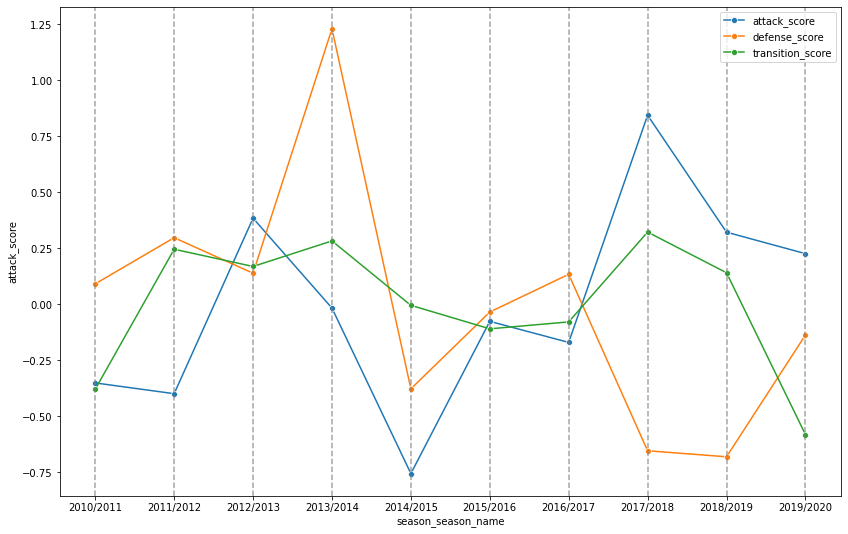

In [53]:
plt.figure(figsize=(14, 9))
for col in categories:
    sns.lineplot(data=plot_comp_agg,x = 'season_season_name' ,y=col, label=col, marker='o')

for i in range(0, len(plot_comp_agg)):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.7)

plt.show()

## Individual stats

In [228]:
pd_comp_agg.columns

Index(['competition_competition_name', 'season_season_id',
       'season_season_name', 'avg_goal_count', 'avg_Attacking_foul_count',
       'avg_clearance_count', 'avg_Transition_pass_count', 'avg_duel_count',
       'avg_block_count', 'avg_ball_recovery_count', 'avg_interception_count',
       'avg_Transition_foul_count', 'avg_shield_count',
       'avg_Attacking_pass_count', 'avg_Defensive_foul_count', 'attack_score',
       'defense_score', 'transition_score'],
      dtype='object')

In [229]:
spec_cols = ['avg_goal_count','avg_clearance_count','avg_Transition_pass_count']

In [230]:
plot_comp_agg = pd_comp_agg.set_index('season_season_name')[spec_cols]
plot_comp_agg.reset_index(inplace = True)
plot_comp_agg.head()

,season_season_name,avg_goal_count,avg_clearance_count,avg_Transition_pass_count
0,2010/2011,1.75,16.25,6.00
1,2011/2012,1.75,25.25,6.50
2,2012/2013,1.75,18.00,9.00
3,2013/2014,2.50,26.25,7.25
4,2014/2015,1.75,18.00,4.00


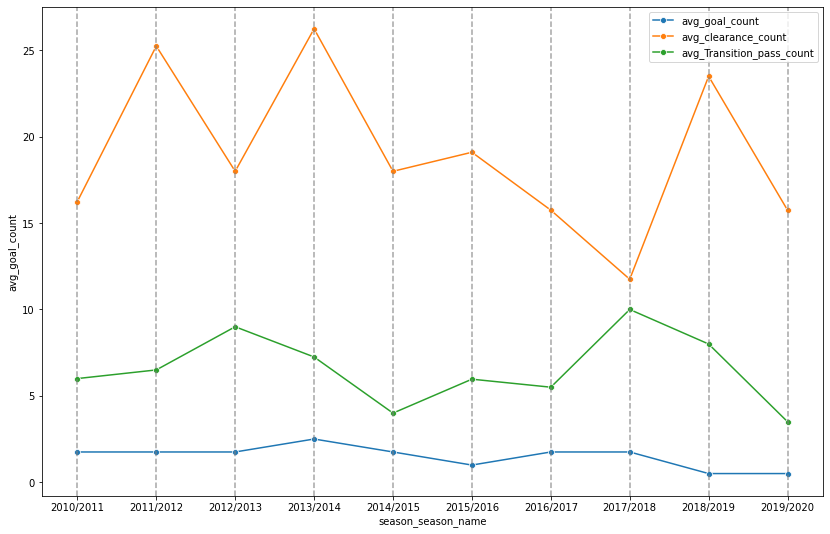

In [231]:
plt.figure(figsize=(14, 9))
for col in spec_cols:
    sns.lineplot(data=plot_comp_agg,x = 'season_season_name' ,y=col, label=col, marker='o')

for i in range(0, len(plot_comp_agg)):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.7)

plt.show()

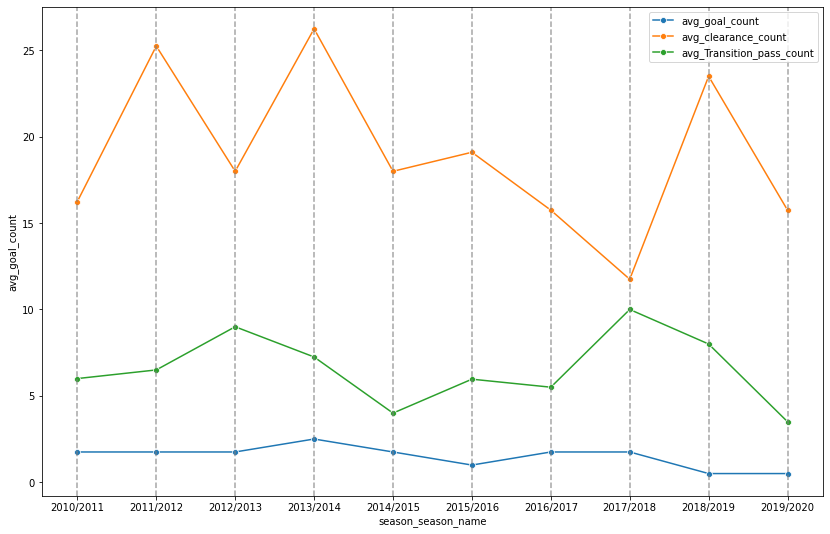

In [232]:
plt.figure(figsize=(14, 9))
for col in spec_cols:
    sns.lineplot(data=plot_comp_agg,x = 'season_season_name' ,y=col, label=col, marker='o')

for i in range(0, len(plot_comp_agg)):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.7)

plt.show()

## Final Plotting

### Barcelona

In [233]:
ls

Analysis-LaLiga_Over_Time.ipynb         Barca_LaLiga_stats.csv
Analysis-League_Play_Style-Copy1.ipynb  RealMadrid_LaLiga_stats.csv
Analysis-League_Play_Style.ipynb        all_teams_LaLiga_stats.csv


In [8]:
df_barca = pd.read_csv('Barca_LaLiga_stats.csv')
df_barca.head()

,competition_competition_name,season_season_id,season_season_name,avg_goal_count,avg_Attacking_foul_count,avg_clearance_count,avg_Transition_pass_count,avg_duel_count,avg_block_count,avg_ball_recovery_count,avg_interception_count,avg_Transition_foul_count,avg_shield_count,avg_Attacking_pass_count,avg_Defensive_foul_count,attack_score,defense_score,transition_score
0,La Liga,22,2010/2011,0.678788,2.681985,22.698485,7.316667,33.715152,18.232576,46.902273,11.821212,1.100000,1.273077,165.207576,3.309211,-0.100218,0.090655,-0.380156
1,La Liga,23,2011/2012,0.795946,2.113363,24.869595,8.125806,36.000676,19.568919,49.033108,11.687838,1.188034,1.289256,173.064189,2.670714,-0.216221,0.296752,0.245118
2,La Liga,24,2012/2013,1.175000,1.735417,22.714063,8.051667,31.735937,17.010938,48.893750,12.760938,1.111111,1.798077,186.417188,2.982639,0.517962,0.138107,0.168225
3,La Liga,25,2013/2014,0.972581,1.966667,26.547581,9.636207,36.529839,22.166935,49.564516,10.797581,1.016667,1.385027,170.852419,3.314815,-0.074515,1.229969,0.282432
4,La Liga,26,2014/2015,0.617105,1.570637,25.840789,7.095313,32.944737,17.407895,46.626316,12.331579,1.300000,1.330769,165.289474,2.283108,-1.311844,-0.378419,-0.005461


In [9]:
df_barca['total_score'] = (df_barca['attack_score']+df_barca['defense_score'])/2
df_barca['total_score'].describe()

count    1.000000e+01
mean    -9.214851e-16
std      3.750862e-01
min     -8.451315e-01
25%     -1.137186e-01
50%      1.774197e-02
75%      1.879413e-01
max      5.777270e-01
Name: total_score, dtype: float64

In [10]:
categories = ['attack_score','defense_score','transition_score','total_score']

In [11]:
plot_comp_agg = df_barca.set_index('season_season_name')[['attack_score','defense_score','transition_score','total_score']]
plot_comp_agg.reset_index(inplace = True)
plot_comp_agg.head()

,season_season_name,attack_score,defense_score,transition_score,total_score
0,2010/2011,-0.100218,0.090655,-0.380156,-0.004782
1,2011/2012,-0.216221,0.296752,0.245118,0.040266
2,2012/2013,0.517962,0.138107,0.168225,0.328035
3,2013/2014,-0.074515,1.229969,0.282432,0.577727
4,2014/2015,-1.311844,-0.378419,-0.005461,-0.845131


In [12]:
plot_comp_agg.head()

,season_season_name,attack_score,defense_score,transition_score,total_score
0,2010/2011,-0.100218,0.090655,-0.380156,-0.004782
1,2011/2012,-0.216221,0.296752,0.245118,0.040266
2,2012/2013,0.517962,0.138107,0.168225,0.328035
3,2013/2014,-0.074515,1.229969,0.282432,0.577727
4,2014/2015,-1.311844,-0.378419,-0.005461,-0.845131


In [20]:
def format_categories(arr):
    return [ ' '.join([__.capitalize() for __ in _.split('_') if __ != 'avg']) for _ in arr]

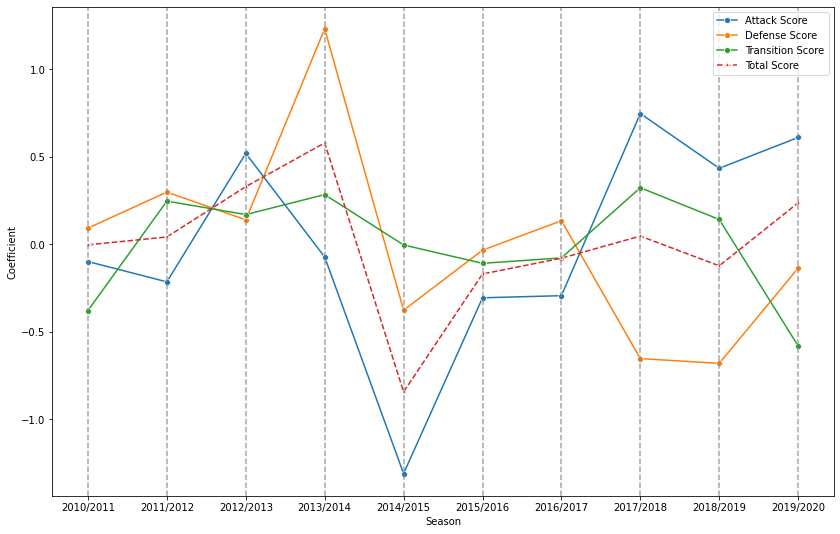

In [24]:
plt.figure(figsize=(14, 9))
cat_frmat = format_categories(categories)
for idx,col in enumerate(categories):
    
    if(col == 'total_score'):
        sns.lineplot(data=plot_comp_agg,x = 'season_season_name' ,y=col, label=cat_frmat[idx], marker='*',linestyle = '--')
    else:
        sns.lineplot(data=plot_comp_agg,x = 'season_season_name' ,y=col, label=cat_frmat[idx], marker='o')

for i in range(0, len(plot_comp_agg)):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.7)

plt.xlabel('Season')
plt.ylabel('Coefficient')
plt.legend()
plt.show()